# Assignment 8: Edge Detection
Tổng quan: Ở bài tập này, chúng ta sẽ thực hành lập trình một số hàm để phát hiện cạnh, đường biên.

Yêu cầu thư viện: OpenCV 3.3, matplotlib 

In [1]:
from IPython.display import Image

import matplotlib.pyplot as plt
import os
import cv2
import numpy as np

# BÀI TẬP VỀ NHÀ

1. Phát hiện làn đường trong trường hợp làn đường bóng, có nhiễu do phản chiếu (lane_detection/lane3.png)
2. Phát hiện làn đường trong trường hợp làn đường bị nhiễu do chất lượng camera thấp (lane_detection/lane4.png)
3. Phát hiện làn đường trên một video

Link tải các video: https://husteduvn-my.sharepoint.com/:u:/g/personal/hieu_tt141567_sis_hust_edu_vn/EZPC362-gLdMg1ro66w1F3EBJM4ELw_edEYrHVm5FL2OeA?e=53wBMV

Gợi ý: Làm quen với việc xử lý video: 

Video là một tập hợp của nhiều frame ảnh liên tiếp. Để xử lý một video, ta phát hiện làn đường từng frame rồi ghép lại thành video.

Xem thêm: https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_gui/py_video_display/py_video_display.html

## Canny edge detection function

In [2]:
def canny_edge_detection(img, blur_ksize=5, threshold1=100, threshold2=200):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_gaussian = cv2.GaussianBlur(gray,(blur_ksize,blur_ksize),0)

    img_canny = cv2.Canny(img_gaussian,threshold1,threshold2)
    return img_canny

## Sobel edge detection function

In [3]:
def sobel_edge_detection(img, blur_ksize=7, sobel_ksize=1, skippingthreshold=30):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_gaussian = cv2.GaussianBlur(gray,(blur_ksize,blur_ksize),0)

    sobelx64f = cv2.Sobel(img_gaussian,cv2.CV_64F,1,0,ksize=sobel_ksize)
    abs_sobel64f = np.absolute(sobelx64f)
    img_sobelx = np.uint8(abs_sobel64f)

    sobely64f = cv2.Sobel(img_gaussian,cv2.CV_64F,0,1,ksize=sobel_ksize)
    abs_sobel64f = np.absolute(sobely64f)
    img_sobely = np.uint8(abs_sobel64f)

    img_sobel = (img_sobelx + img_sobely)//2
    for i in range(img_sobel.shape[0]):
        for j in range(img_sobel.shape[1]):
            if img_sobel[i][j] < skippingthreshold:
                img_sobel[i][j] = 0
            else:
                img_sobel[i][j] = 255
    return img_sobel

# 1. lane3.png

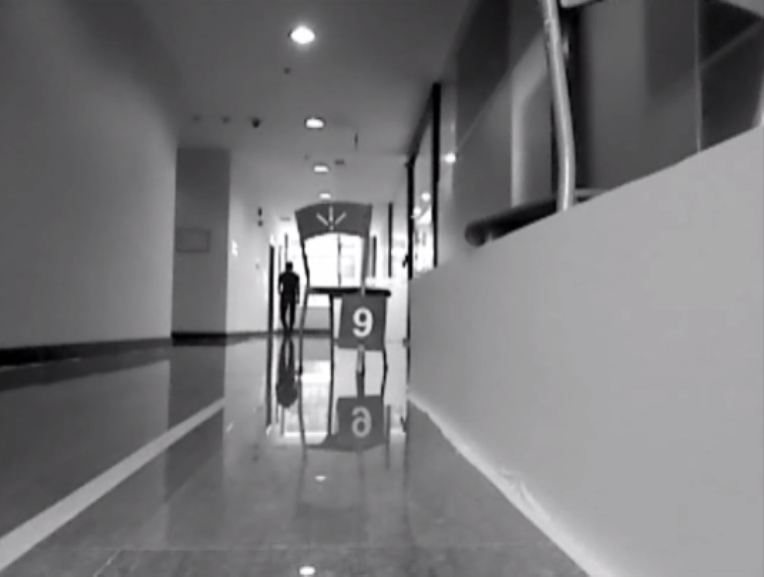

In [4]:
Image('lane_detection/lane3.png')

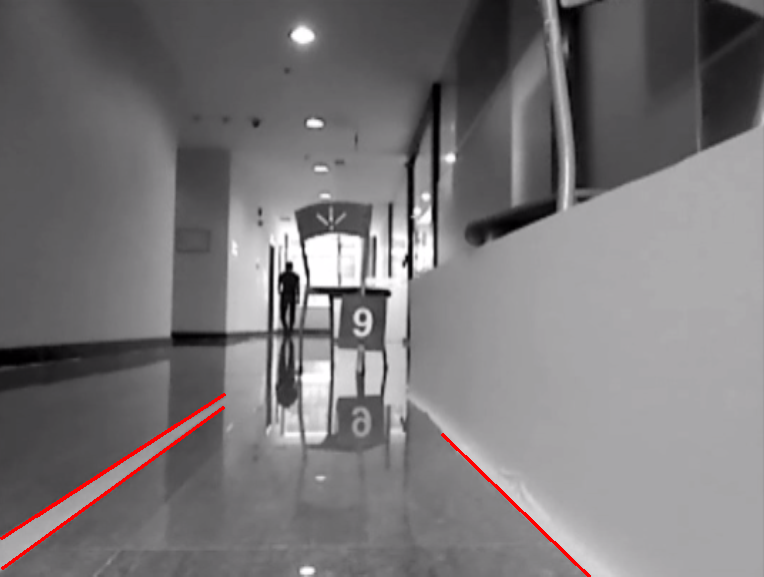

In [5]:
img=cv2.imread('lane_detection/lane3.png')
edges = canny_edge_detection(img, 3, 85, 245)

minLineLength = 90
maxLineGap = 20
lines = cv2.HoughLinesP(edges,1,np.pi/180,140,minLineLength=minLineLength,maxLineGap=maxLineGap)

for line in lines:
    for x1,y1,x2,y2 in line:
        cv2.line(img,(x1,y1),(x2,y2),(0,0,255),2)
cv2.imwrite('lane_detection/new_lane3.png',img)
Image('lane_detection/new_lane3.png')
# cv2.imwrite('lane_detection/edges_lane3.png',edges)
# Image('lane_detection/edges_lane3.png')


# 2. lane4.png

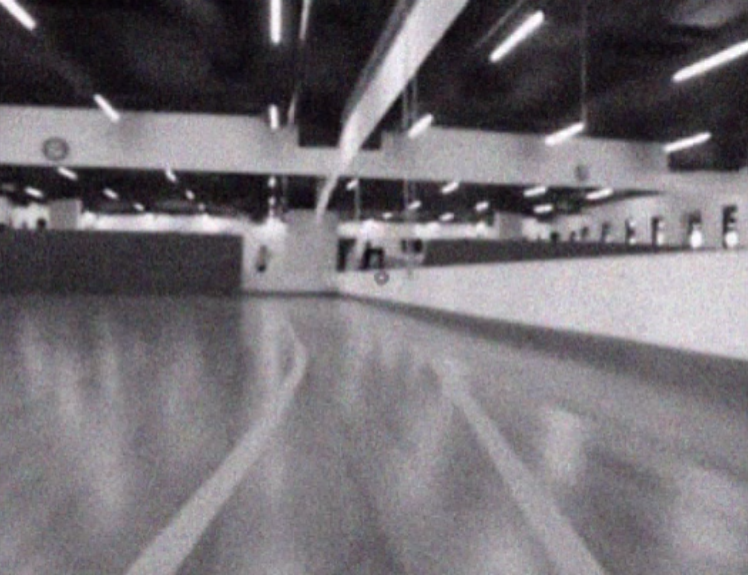

In [6]:
Image('lane_detection/lane4.png')

Sobel edge detection along y-axis

In [7]:
def sobel_edge_detection_y(img, blur_ksize=7, sobel_ksize=1, threshold1=10,threshold2=1000):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_gaussian = cv2.GaussianBlur(gray,(blur_ksize,blur_ksize),0)

    sobelx64f = cv2.Sobel(img_gaussian,cv2.CV_64F,1,0,ksize=sobel_ksize)
    abs_sobel64f = np.absolute(sobelx64f)
    img_sobel = np.uint8(abs_sobel64f)
    
    for i in range(img_sobel.shape[0]):
        for j in range(img_sobel.shape[1]):
            if (img_sobel[i,j] < threshold1) or (img_sobel[i,j]>threshold2):
                img_sobel[i][j] = 0
            else:
                img_sobel[i,j] = 255
    return img_sobel

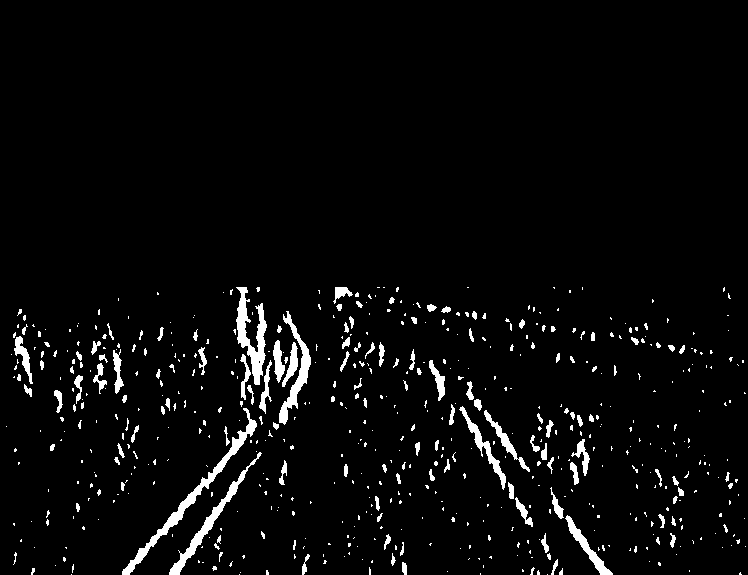

In [8]:
img=cv2.imread('lane_detection/lane4.png')
# img=cv2.medianBlur(img,5)
# img=cv2.GaussianBlur(img,(11,11),0)
# cv2.imwrite('gaus.png',img)
# Image('gaus.png')

# edges = canny_edge_detection('./lane_detection/lane4.png', 11, 20, 30)

edges=sobel_edge_detection_y(img,9,3,20)
edges[:edges.shape[0]//2,:]=0

# cv2.imwrite('lane_detection/sobel_lane4.png',edges)
# Image('lane_detection/sobel_lane4.png')

cv2.imwrite('lane_detection/edges_lane4.png',edges)
Image('lane_detection/edges_lane4.png')

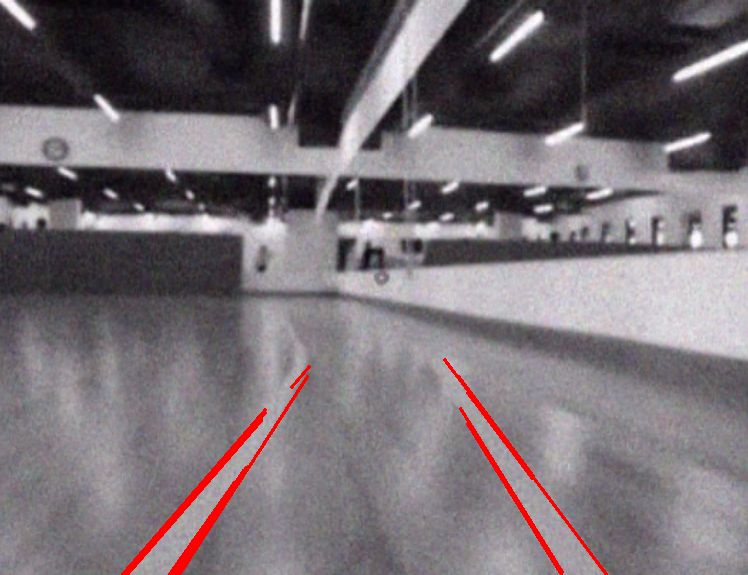

In [9]:
minLineLength =10
maxLineGap = 20
lines = cv2.HoughLinesP(edges,1,np.pi/180,150,minLineLength=minLineLength,maxLineGap=maxLineGap)

for line in lines:
    for x1,y1,x2,y2 in line:
        cv2.line(img,(x1,y1),(x2,y2),(0,0,255),2)
cv2.imwrite('lane_detection/new_lane4.png',img)
Image('lane_detection/new_lane4.png')

# Video

## Video processing function

In [10]:
def processVideo(input_path,output_path,process):
    cap = cv2.VideoCapture(input_path)

    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter(output_path,fourcc, 20.0, (720,576))
    while(cap.isOpened()):
        ret, frame = cap.read()
        if ret is False:
            break
        new_frame=process(frame)
        out.write(new_frame)
        cv2.imshow('video',new_frame)
        
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    out.release()
    cv2.destroyAllWindows()

In [11]:
import math
def direction(line):
    x1,y1,x2,y2=line[0]
    return math.atan2(abs(y2-y1)+0.01,abs(x2-x1)+0.01)

## Lane 1

In [12]:
def process_lane1(img):
    edges = canny_edge_detection(img, 11, 40, 80)
    edges[:edges.shape[0]//2,:]=0

    minLineLength = 40
    maxLineGap = 30
    lines = cv2.HoughLinesP(edges,1,np.pi/180,80,minLineLength=minLineLength,maxLineGap=maxLineGap)
    for line in lines:
        for x1,y1,x2,y2 in line:
            if direction(line)<10*np.pi/180 or direction(line)>80*np.pi/180:
                continue
            cv2.line(img,(x1,y1),(x2,y2),(0,255,0),2)
    return img

In [13]:
processVideo('video_lane/lane1.avi','video_lane/ouput1.avi',process_lane1)

## Lane 2

In [14]:
def process_lane2(img):
#     edges = canny_edge_detection(img, 11, 40, 100)
    edges=sobel_edge_detection(img,17,1,20) 
    edges[:edges.shape[0]//2,:]=0
    
    minLineLength = 20
    maxLineGap = 10
    lines = cv2.HoughLinesP(edges,1,np.pi/180,40,minLineLength=minLineLength,maxLineGap=maxLineGap)
    for line in lines:
        for x1,y1,x2,y2 in line:
            if direction(line)<5*np.pi/180 or direction(line)>85*np.pi/180:
                continue
            cv2.line(img,(x1,y1),(x2,y2),(0,255,0),2)
    return img

In [15]:
processVideo('video_lane/lane2.avi','video_lane/ouput2.avi',process_lane2)

## Lane 3 

In [16]:
def process_lane3(img):
    edges = canny_edge_detection(img, 5, 40, 80)
    edges[:2*edges.shape[0]//3,:]=0

    minLineLength = 20
    maxLineGap = 20
    lines = cv2.HoughLinesP(edges,1,np.pi/180,80,minLineLength=minLineLength,maxLineGap=maxLineGap)
    for line in lines:
        for x1,y1,x2,y2 in line:
            if abs(x2-x1)<=10:
                continue
            cv2.line(img,(x1,y1),(x2,y2),(0,255,0),2)
    return img

In [17]:
processVideo('video_lane/lane3.avi','video_lane/ouput3.avi',process_lane3)

## Lane 4

In [18]:
def process_lane4(img):
    edges=sobel_edge_detection_y(img,13,3,30)
    edges[:edges.shape[0]//2,:]=0

    minLineLength =10
    maxLineGap = 30
    lines = cv2.HoughLinesP(edges,1,np.pi/180,70,minLineLength=minLineLength,maxLineGap=maxLineGap)

    for line in lines:
        for x1,y1,x2,y2 in line:
            if direction(line)<5*np.pi/180 or direction(line)>85*np.pi/180:
                continue
            cv2.line(img,(x1,y1),(x2,y2),(0,255,0),2)
    return img

In [19]:
processVideo('video_lane/lane4.avi','video_lane/ouput4.avi',process_lane4)

Output is stored at:
https://drive.google.com/drive/folders/1A75eCMX5SOE3l6Vqlwj_-imZczJQuRk6?usp=sharing 